# Table of Contents

1. [Importing Necessary Dependencies](#importing-necessary-dependencies)
2. [Loading the Datasets](#loading-the-datasets)
3. [Defining Helper Functions](#defining-helper-functions)
4. [Data Preprocessing](#data-preprocessing)
5. [Model Training](#model-training)
6. [Model Evaluation](#model-evaluation)

# Importing Necessary Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.utils import class_weight
from xgboost import XGBClassifier

# Loading the Datasets

In [2]:
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_test = pd.read_parquet('../data/processed/X_test.parquet')
y_train = pd.read_parquet('../data/processed/y_train.parquet')
y_test = pd.read_parquet('../data/processed/y_test.parquet')

In [3]:
X_train.drop(columns="code_snippet", inplace=True)
X_test.drop(columns="code_snippet", inplace=True)

In [4]:
X_train.head()

,loc,num_args,num_returns,num_variables,num_function_calls,has_decorators,uses_globals,is_recursive,estimated_difficulty,estimated_bugs,has_docstring,docstring_length,num_comments,name_length,is_name_well_formed,bad_variable_names_count,max_return_length,estimated_complexity
0,5,1,0,0,4,False,False,False,0.000000,0.000000,False,0,0,7,True,0,0,2
1,17,1,0,6,9,False,False,False,0.000000,0.000000,True,2,0,9,True,3,0,1
2,34,2,1,8,4,False,False,False,2.500000,0.015850,True,13,0,30,True,0,23,2
3,27,2,1,7,11,False,False,False,2.647059,0.040135,True,6,0,13,True,2,49,8
4,25,3,0,4,5,False,False,False,0.500000,0.001585,True,10,2,15,True,0,0,5


In [5]:
y_train.head()

,quality
0,good
1,bad
2,bad
3,good
4,good


In [6]:
X_train = X_train[~X_train.duplicated()]
X_test = X_test[~X_test.duplicated()]

train_keep_indices = X_train.index
test_keep_indices = X_test.index

# Filter y_train and y_test to match the deduplicated X's
y_train = y_train.loc[train_keep_indices]
y_test = y_test.loc[test_keep_indices]

In [7]:
X_train.describe()

,loc,num_args,num_returns,num_variables,num_function_calls,estimated_difficulty,estimated_bugs,docstring_length,num_comments,name_length,bad_variable_names_count,max_return_length,estimated_complexity
count,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000,525775.000000
mean,21.096163,2.107280,0.749956,3.819314,7.518397,0.944986,0.015863,2.076826,1.024429,18.580125,0.680101,25.522959,3.434591
std,36.400305,2.430828,1.208527,7.321618,14.364684,1.591049,1.194456,8.346226,3.276523,12.470378,2.232101,685.629577,5.320168
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,6.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,1.000000
50%,12.000000,2.000000,1.000000,2.000000,4.000000,0.500000,0.001585,0.000000,0.000000,16.000000,0.000000,0.000000,2.000000
75%,25.000000,3.000000,1.000000,5.000000,9.000000,1.066667,0.008422,1.000000,1.000000,24.000000,1.000000,26.000000,4.000000
max,6220.000000,374.000000,140.000000,1710.000000,2714.000000,127.500000,859.116896,838.000000,263.000000,176.000000,260.000000,478196.000000,500.000000


In [8]:
y_train.describe()

,quality
count,525775
unique,2
top,bad
freq,274103


In [9]:
X_train.dtypes

loc                           int64
num_args                      int64
num_returns                   int64
num_variables                 int64
num_function_calls            int64
has_decorators                 bool
uses_globals                   bool
is_recursive                   bool
estimated_difficulty        float64
estimated_bugs              float64
has_docstring                  bool
docstring_length              int64
num_comments                  int64
name_length                   int64
is_name_well_formed            bool
bad_variable_names_count      int64
max_return_length             int64
estimated_complexity          int64
dtype: object

In [10]:
y_train.dtypes

quality    category
dtype: object

# Defining Helper Functions

In [11]:
def plot_learning_curve(model, X, y, cv=5, title="Learning Curve"):
	train_sizes, train_scores, val_scores = learning_curve(
		model, X, y, cv=cv, scoring='accuracy',
		train_sizes=np.linspace(0.1, 1.0, 10),
		n_jobs=-1
	)
	
	plt.figure(figsize=(10, 6))
	plt.plot(
		train_sizes, np.mean(train_scores, axis=1), label='Training Score'
	)
	plt.plot(
		train_sizes, np.mean(val_scores, axis=1), label='Validation Score'
	)
	plt.fill_between(
		train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
		np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1
	)
	plt.fill_between(
		train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
		np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1
	)
	
	plt.title(title)
	plt.xlabel("Training Examples")
	plt.ylabel("Accuracy Score")
	plt.legend()
	plt.grid()
	plt.show()

# Data Preprocessing

## Converting Boolean Columns to Numerical (0, 1)

In [12]:
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

## Scaling the Data

### Identifying numerical columns (excluding boolean/binary columns)

In [13]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in bool_cols]

### Scaling

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('bool', 'passthrough', bool_cols)  # Skip scaling for boolean columns
    ],
    remainder='passthrough'  # This will handle any other columns if they exist
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

### Converting to DataFrame to maintain column names

In [15]:
feature_names = numerical_cols + list(bool_cols)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

## Encoding the Target Variable

In [16]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.squeeze())

## Calculating Class Weights
This step is optional, but can help balance the dataset and improve the model's performance.

In [17]:
classes = np.unique(y_train_encoded)
weights = class_weight.compute_sample_weight('balanced', y_train_encoded)
weights

array([1.04456396, 0.9590829 , 0.9590829 , ..., 1.04456396, 0.9590829 ,
       0.9590829 ])

# Model Training

In [18]:
model = XGBClassifier(
	n_estimators=150,
	max_depth=30,
	reg_alpha=0.1,
    reg_lambda=0.1,
	learning_rate=0.05,
	subsample=0.9,
	colsample_bytree=0.9,
	random_state=42,
	objective='binary:hinge',
	eval_metric='logloss',
	n_jobs=-1
)

model.fit(
	X_train_scaled,
	y_train_encoded,
	verbose=True
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, ...)

# Model Evaluation

In [19]:
y_pred_encoded = model.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.80      0.81      0.80     71690
        good       0.80      0.79      0.80     72056

    accuracy                           0.80    143746
   macro avg       0.80      0.80      0.80    143746
weighted avg       0.80      0.80      0.80    143746



In [20]:
scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.78840759 0.77886929 0.77747135 0.77543626 0.7725548 ]
Mean cross-validation score: 0.7785478579240169


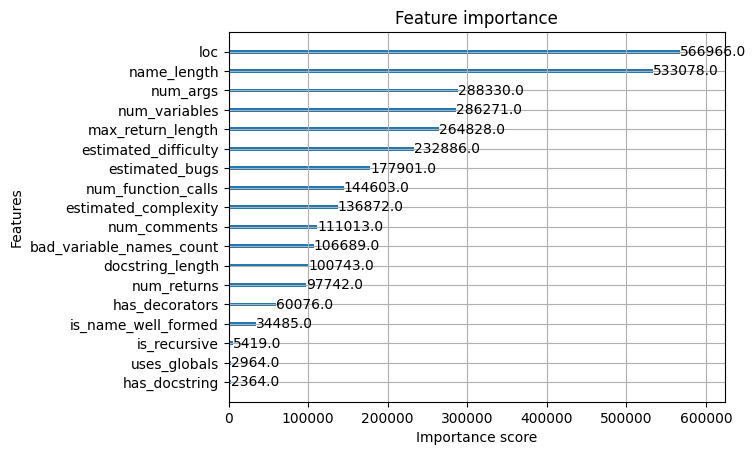

In [21]:
xgb.plot_importance(model)
plt.show()

In [1]:
plot_learning_curve(model, X_train_scaled, y_train_encoded, cv=3, title="XGBoost Learning Curve")

NameError: name 'plot_learning_curve' is not defined